In [1]:
import pandas as pd
import numpy as np
import plotnine as pln
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from utils import merge_small_groups, replace_rare_values

In [4]:
bookings = pd.read_csv('../data/hotel_bookings.csv')
bookings.loc[:, 'y'] = (bookings['stays_in_week_nights'] + bookings['stays_in_weekend_nights']) >= 7
# we drop the columns that were used to create our dependent variable so that we do not include it accidentaly into training
bookings = bookings.drop(columns=['stays_in_week_nights', 'stays_in_weekend_nights'])

In [5]:
bookings.shape

(119390, 31)

In [6]:
# we may need months to be sorted or we may not - better safe than sorry
month_cat = pd.CategoricalDtype(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
                                ordered=True)
bookings.loc[:, 'arrival_date_month'] = bookings.loc[:, 'arrival_date_month'].astype(month_cat)

## Some EDA, data munging and cleaning

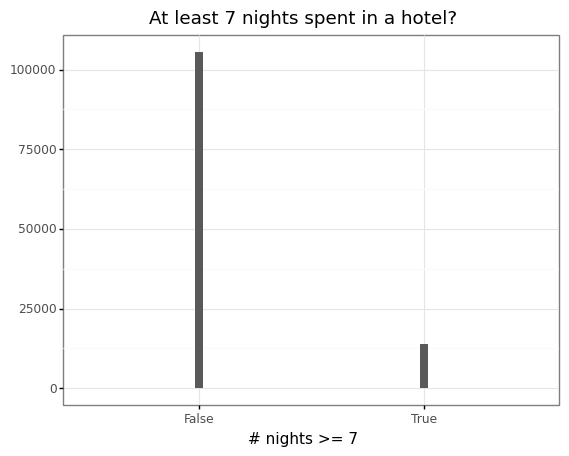

In [7]:
# let's start with the plot of the independent variable (y)
(pln.ggplot(bookings)
 + pln.geom_histogram(pln.aes(x='factor(y)'), bins=30)
 + pln.labs(x='# nights >= 7', y='', title='At least 7 nights spent in a hotel?')
 + pln.theme_bw()
).draw();

In [8]:
round(bookings['y'].value_counts().max() / bookings['y'].value_counts().sum(), 3)

0.883

It seems that the distribution is imbalanced. The imbalance of (around) 1:9 is considerable, but (at least initially) doesn't require any special cross-validation schemes, so we proceed normally. Even more so, that for the modeling we will be using LightGBM algorithm. With proper hyperparameter tuning we can alleviate the imbalance-derived issues.

In [9]:
# reservation_status_date seems to be a technical column and we should not (probably) be using it in the training
# all we need is the status and not exactly when was it set
bookings = bookings.drop(columns=['reservation_status_date'])

In [10]:
# we need to sort out categorical columns differently - they cannot be used as-is in the modeling part
categorical_columns = bookings.select_dtypes(include=['object', 'category']).columns

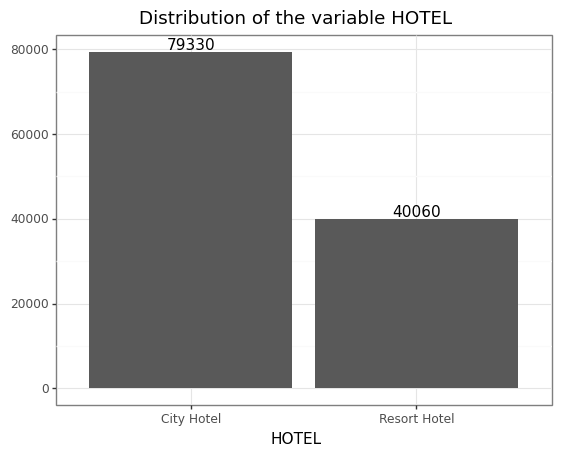

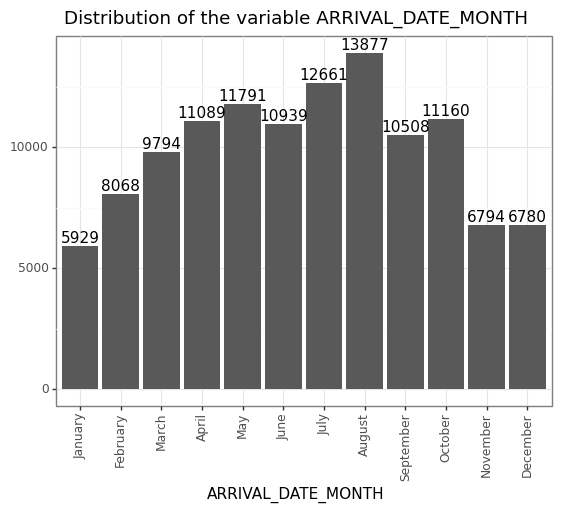

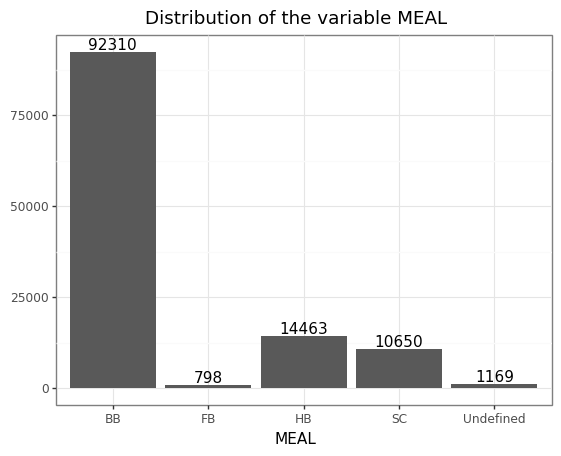

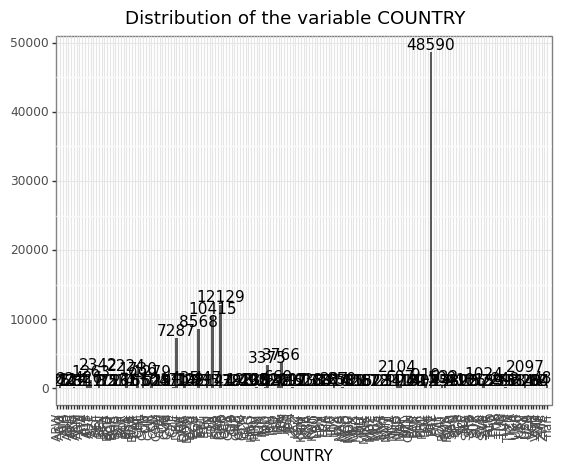

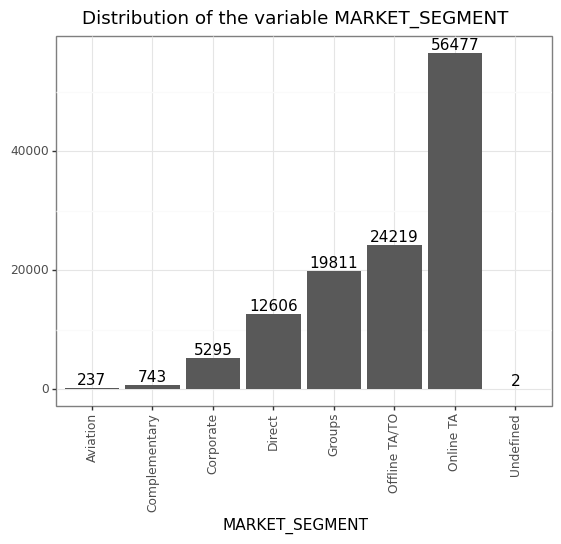

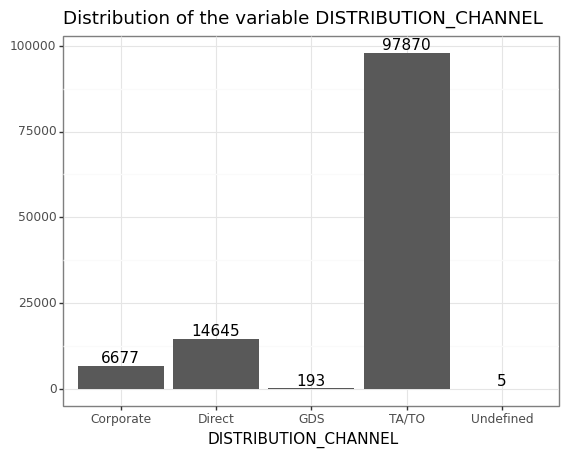

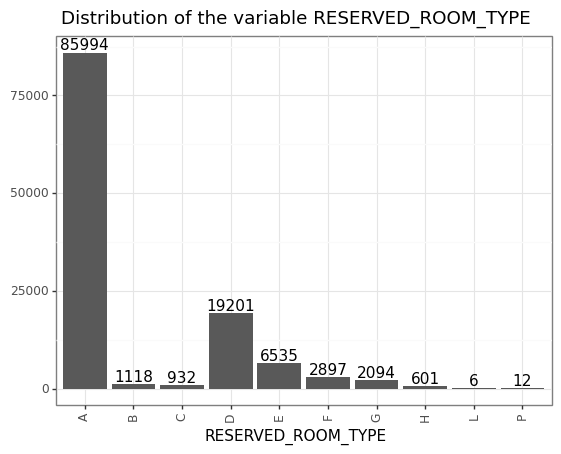

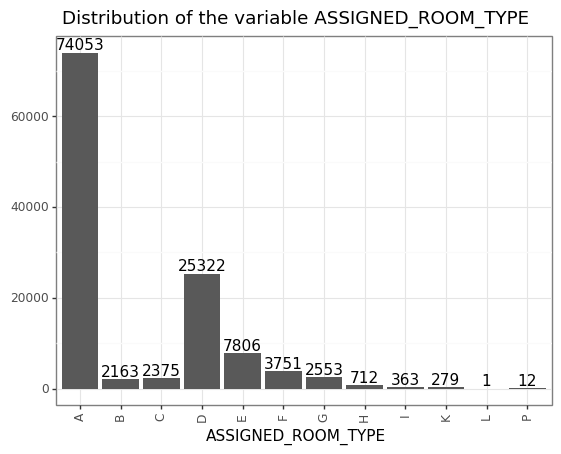

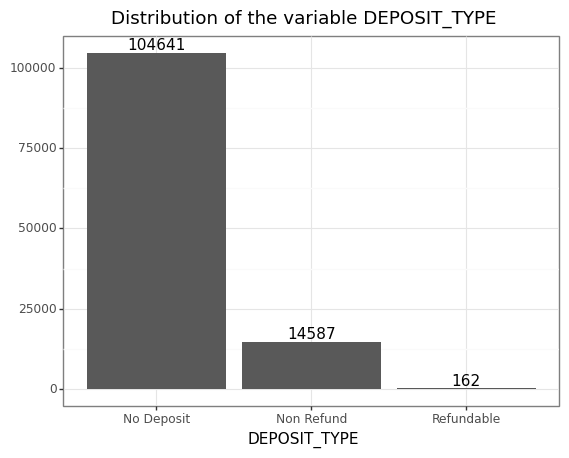

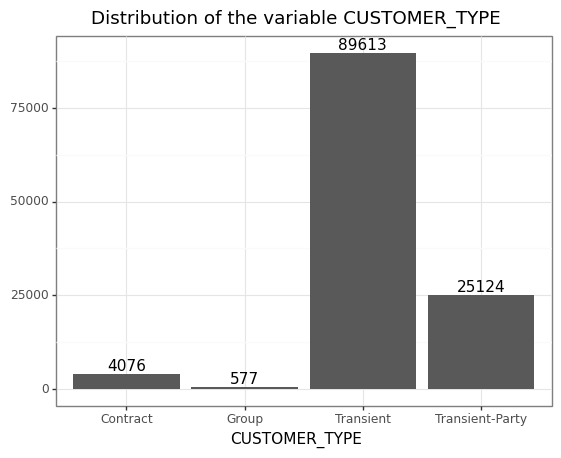

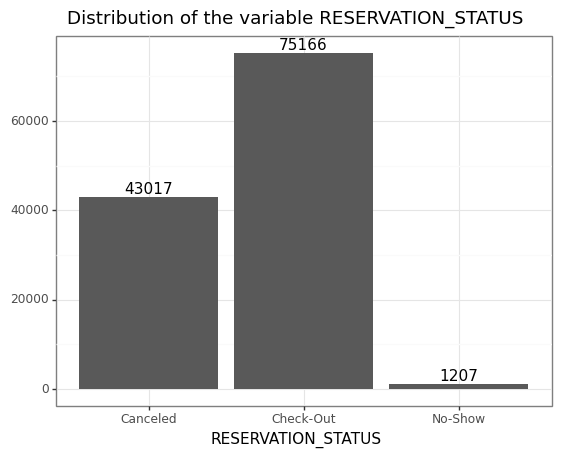

In [9]:
# let's plot a barplot for every categorical variable to find out their distributions
for cat_col in categorical_columns:
    n_cats = bookings[cat_col].unique().shape[0]
    g = (pln.ggplot(pln.aes(x=cat_col), data=bookings)
     + pln.geom_bar()
     + pln.geom_text(pln.aes(label='stat(count)'), stat='count', nudge_y=0.125, va='bottom')
     + pln.labs(y='', x=cat_col.upper(), title=f'Distribution of the variable {cat_col.upper()}')
     + pln.theme_bw()
    )
    if n_cats > 5:
        g = g + pln.theme(axis_text_x=pln.element_text(angle=90))
    g.draw();

At this point, we can observe two problems we need to deal with:
- There is a number of small classes that will not guarantee generalization if included into training. We will set the arbitrary threshold to 200 - all the classes with the count below that value will be dropped from the dataset. There is only a number of such classes so the overall number of observations will not change significantly.
- We cannot, however, apply this procedure to the `COUTNRY` variable, as it consists mainly of small classes, since there are numerous countries in the dataset. If we removed them, we would lose quite a significant number of observations (~3500). We will therefore merge all countries with less than 200 observations into one group called `OTH` (other) and treat them as one. We will eventually lose some signal that is contained in this variable (if any), but on the other hand, the findings will be more generalizable and we will avoid the situation where we are trying to fit to small groups that are potentially less informative (or straightforwardly misleading).

#### Cleaning the categorical variables

In [11]:
# first, let's merge small groups into the OTH (other) group for the `country` column
bookings = merge_small_groups(bookings, 'country')

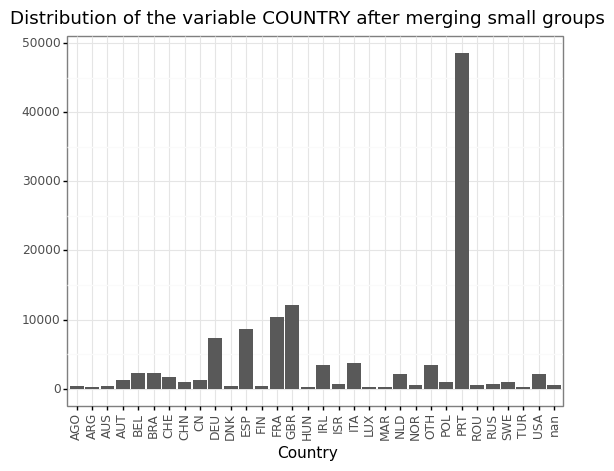

In [13]:
# plot for verification
(pln.ggplot(pln.aes(x='country'), data=bookings)
 + pln.geom_bar()
 + pln.labs(y='', x='Country', title=f'Distribution of the variable COUNTRY after merging small groups')
 + pln.theme_bw()
 + pln.theme(axis_text_x=pln.element_text(angle=90))
).draw();

Let's now drop the infrequent groups - we will replace these values with NANs and drop any row with any NAN value. But before we do so we should check whether NANs already exist in the dataset.

In [14]:
bookings.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type   

There are two columns that have pretty significant number of NANs - `agent` and `company`. We will drop them from the dataset as imputing them is difficult to carry out, if not impossible, since the lack of agents' or companies' IDs may be an indication of more prevalent issue. For instance, the missing IDs may not be present in the reservation system and not merely faulty entries that were not properly noted.

In [15]:
bookings = bookings.drop(columns=['agent', 'company'])

In [16]:
# now we replace 'rare' classes with NANs
bookings = replace_rare_values(bookings, categorical_columns)

In [17]:
# we check once again whether the replacing worked and it seems so
bookings.isna().sum()

hotel                               0
is_canceled                         0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
adults                              0
children                            4
babies                              0
meal                                0
country                           488
market_segment                      2
distribution_channel              198
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                 18
assigned_room_type                 13
booking_changes                     0
deposit_type                      162
days_in_waiting_list                0
customer_type                       0
adr                                 0
required_car_parking_spaces         0
total_of_special_requests           0
reservation_

In [18]:
# now we can remove all the rows with NANs
n_observations_before = bookings.shape[0]
bookings = bookings.dropna()
print(f'{n_observations_before - bookings.shape[0]} rows were removed.')
del n_observations_before

856 rows were removed.


#### Encode categorical / string variables

In [19]:
from sklearn.preprocessing import OneHotEncoder

In [20]:
all_encoded_columns = []
for col in categorical_columns:
    ohe = OneHotEncoder(drop='first')  # we drop one of the classes to alleviate the burden of colinearity
    encoded_columns = pd.DataFrame(ohe.fit_transform(bookings[[col]].values).toarray(), columns=[f'{col}_{x}' for x in ohe.categories_[0][1:]])
    all_encoded_columns.append(encoded_columns)

all_encoded_columns = pd.concat(all_encoded_columns, axis=1)
# replace categorical columns with their encoded counterparts
bookings = bookings.merge(all_encoded_columns, left_index=True, right_index=True).drop(columns=categorical_columns)

In [21]:
bookings.shape

(117678, 93)

#### Draw clustermap

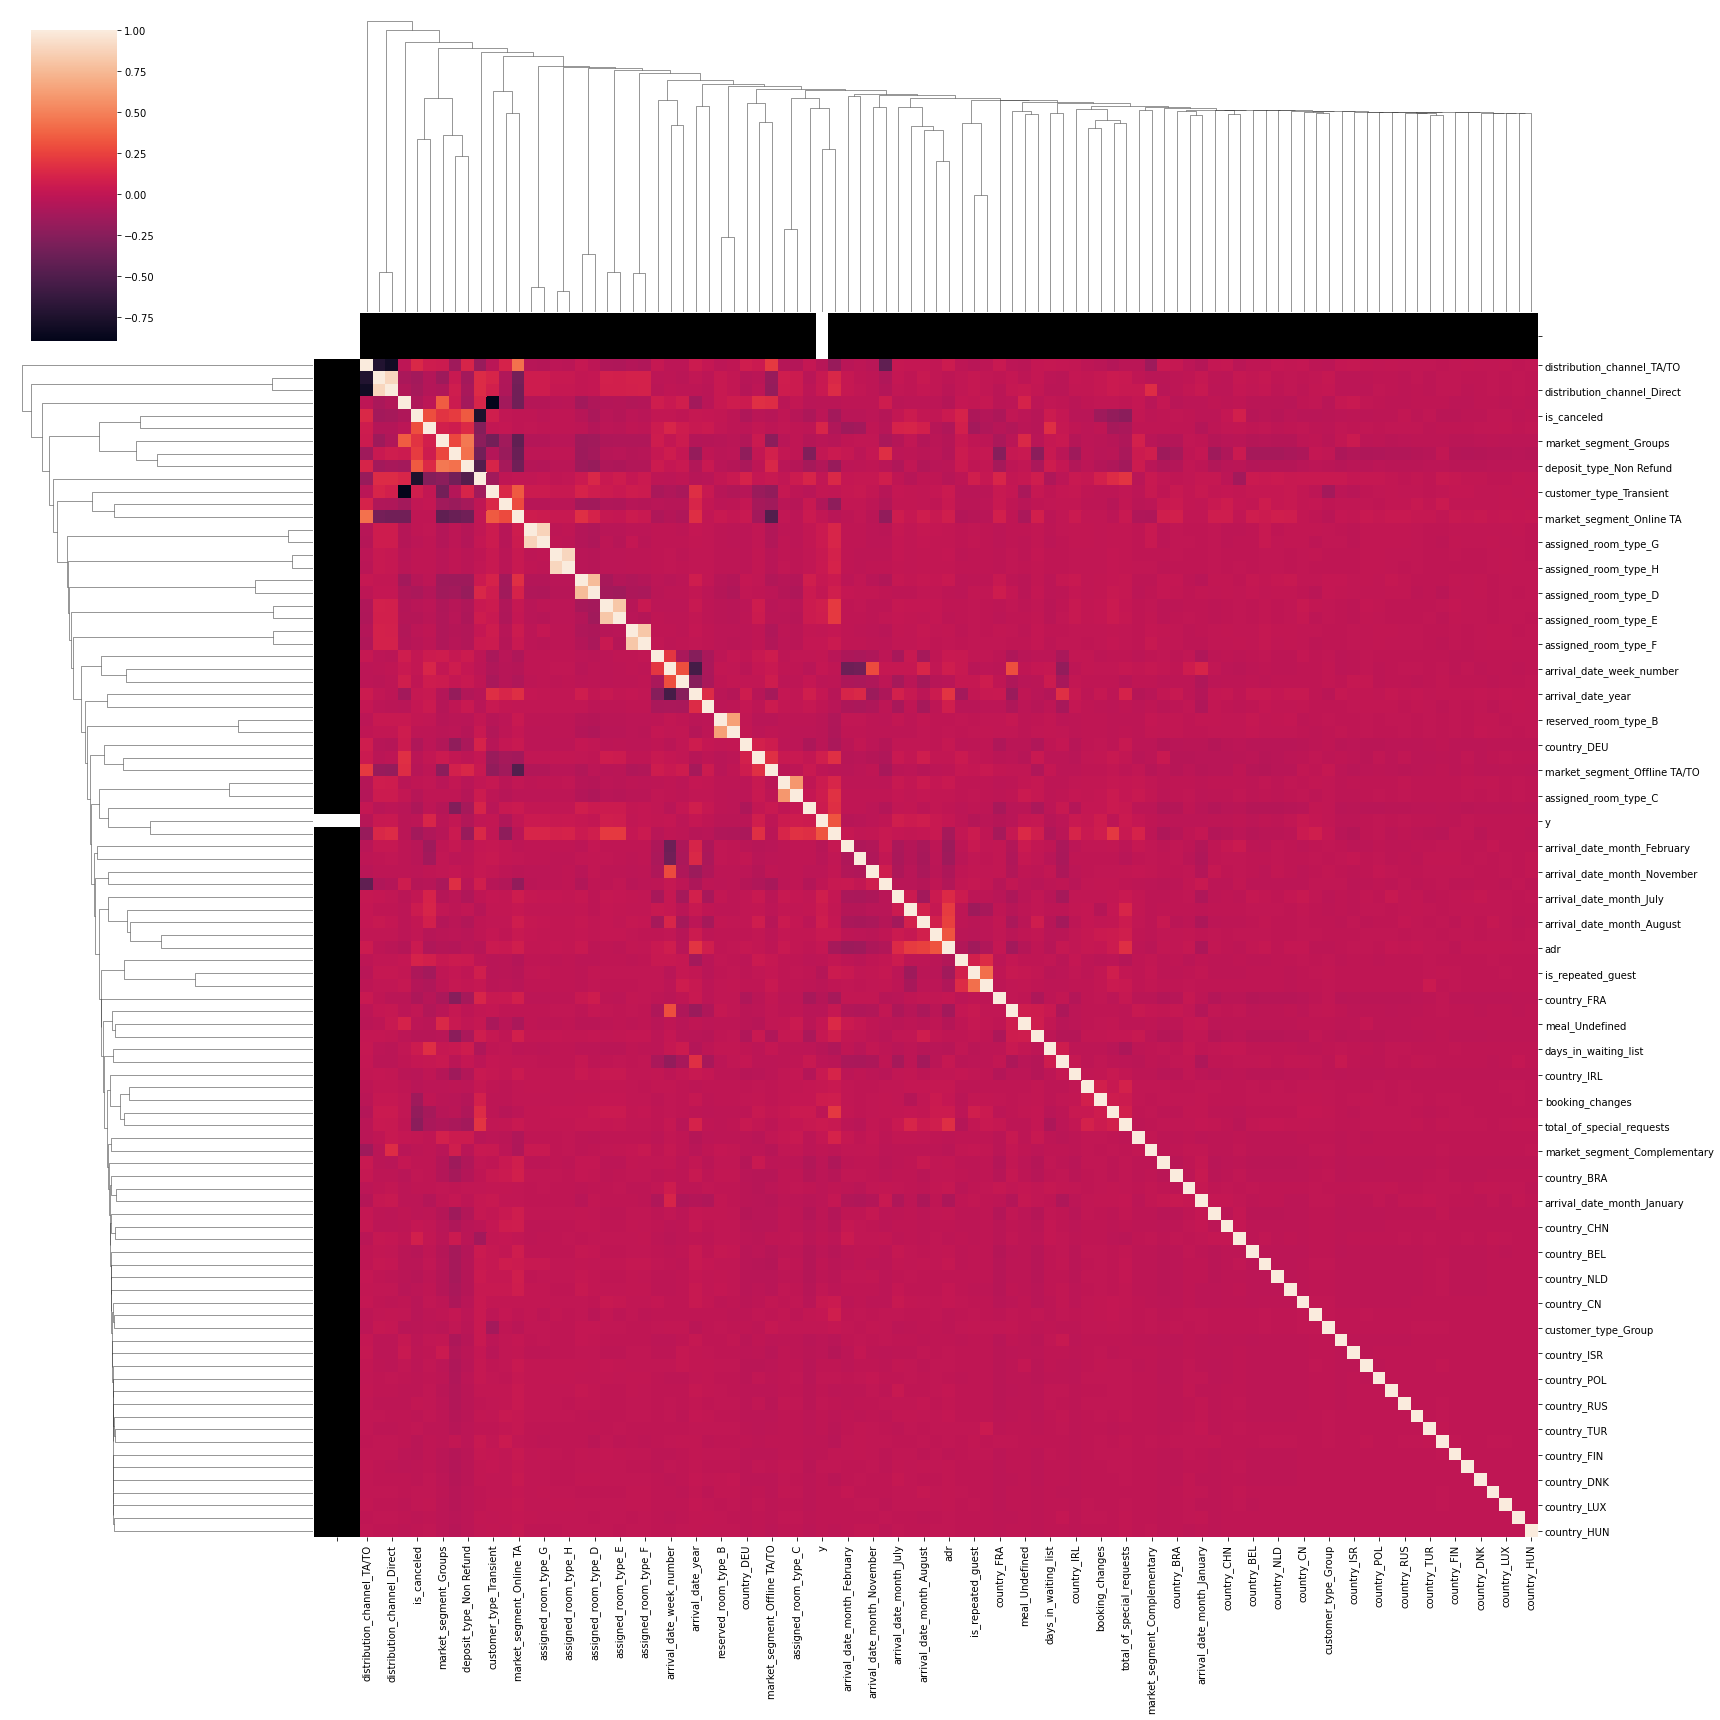

In [22]:
# white color to distinguish independent variable from dependent variables
cols = pd.Series(np.where(bookings.columns=='y', '#FFFFFF', '#000000'), bookings.columns)
sns.clustermap(bookings.corr(), figsize=(24, 24), row_colors=cols, col_colors=cols)
plt.show()

From the clustermap we can conclude the following:
1. The overall structure of correlations in the graph is scarce - there aren't many highly-correlated pairs of variables. There are some that stand out like `reserved_` and `assigned_room_type` or `market_segment` and `distribution_channel_Direct`. Which, given by their nature, should not be surprising.
2. Strong, negative, correlations (close to -1) were introduced through the elimination of infrequent classes in one of the previous steps. We were left, in some cases, with three classes and one of them was dropped during encoding. We can imagine that in some cases the least frequent class was dropped in such a way and the two remaining classes are their almost perfect reciprocals, hence high correlation.
3. Dependent variable is relatively low correlated with other features - the one that seems to show the highest correlation is `hotel_Resort Hotel`.

## Modeling part

In [32]:
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import StratifiedKFold, train_test_split

In [24]:
rskf = StratifiedKFold(n_splits=5, n_repeats=1, random_state=90)

In [36]:
lgbm_classifier = LGBMClassifier(n_estimators=250, n_jobs=3, random_state=90)
lgbm_classifier = BayesSearchCV(lgbm_classifier, 
                                {'learning_rate': Real(0.01, 0.35, 'uniform'),
                                 'reg_alpha': Real(1e-6, 1, 'log-uniform'), 
                                 'reg_lambda': Real(1e-6, 1, 'log-uniform'), 
                                 'subsample': Real(0.5, 1, 'uniform'), 
                                 'colsample_bytree': Real(0.5, 1, 'uniform'),
                                 'max_depth': Integer(10, 30)
                                },
                                scoring='roc_auc',
                                n_iter=30,
                                n_jobs=2,
                                n_points=1,
                                cv=rskf,
                                random_state=90)

In [33]:
# let's leave 2500 observations aside as test size
train_X, test_X, train_y, test_y = train_test_split(bookings.drop(columns=['y']), bookings['y'], test_size=2500)

In [37]:
lgbm_classifier.fit(train_X, train_y)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=None),
              estimator=LGBMClassifier(n_estimators=250, n_jobs=3,
                                       random_state=90),
              n_iter=30, n_jobs=2, random_state=90, scoring='roc_auc',
              search_spaces={'colsample_bytree': Real(low=0.5, high=1, prior='uniform', transform='identity'),
                             'learning_rate': Real(low=0.01, high=0.35, prior='uniform', transform='identity'),
                             'max_depth': Integer(low=10, high=30, prior='uniform', transform='identity'),
                             'reg_alpha': Real(low=1e-06, high=1, prior='log-uniform', transform='identity'),
                             'reg_lambda': Real(low=1e-06, high=1, prior='log-uniform', transform='identity'),
                             'subsample': Real(low=0.5, high=1, prior='uniform', transform='identity')})

In [39]:
print(f"validation score: {np.round(lgbm_classifier.best_score_, 3)}")
print(f"test score: {np.round(lgbm_classifier.score(test_X, test_y), 3)}")

validation score: 0.907
test score: 0.896


In [41]:
lgbm_classifier.best_estimator_.feature_importances_

array([  92, 1668,  190, 1017, 1097,  136,   77,    7,   10,   27,   26,
        150,   29, 1502,   28,  235,   95,   36,   15,   32,   11,   42,
         46,   32,   27,   16,   32,   30,   11,   34,   19,    1,    0,
          1,    5,    7,   10,    2,    1,   10,   18,    2,   27,    5,
         21,   28,    1,    9,    2,   11,    0,    1,    4,    2,    9,
          6,   43,    4,    4,    0,    0,    9,    3,    9,   23,   48,
         26,   35,   20,   15,    5,    4,   31,   17,   10,    8,    3,
          5,    3,   33,   17,   10,    5,    4,    4,    0,   24,    4,
         39,   29,   50,    4], dtype=int32)

Even though both the results on the validation and test sets are decent, to say the least, it would be beneficial to validate the model in a proper cross-validation (for instance, via `sklearn.model_selection.cross_validate()`. We didn't do it here, for computational reasons. It would also allow us to determine dipersion of the classificator's performance with respect to the random selection of train set.

#### Shapley explanations